# Rescheduling mit Flow Time
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.production_process import initialize as init
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.lp import flowtime_scheduling as lp_ft_schedule
from src.models.lp import flowtime_rescheduling as lp_ft_reschedule

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60*15 # 15 min

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
6,0,6,M06,62
7,0,7,M07,56
...,...,...,...,...
92,9,2,M02,61


## 1) Aufträge generieren für 1 Tag

In [4]:
day_count = 1

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = day_count, shift_length = 1440,
                                                        u_b_mmax = 0.95, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,0,8,75,1440
1,1,6,123,1440
2,2,0,187,1440
3,3,2,231,1440
4,4,3,271,1440
5,5,1,472,1440
6,6,9,749,1440
7,7,5,877,1440
8,8,4,936,1440
9,9,7,951,1440


## I) Complete Scheduling

In [5]:
# Scheduling
df_schedule = lp_ft_schedule.solve_jssp(df_jssp, df_jobs_arrivals, solver= "HiGHS", var_cat="Integer", msg=False, timeLimit=max_time, gapRel= 0.05)
df_schedule

BigM: 10000

Solver-Informationen:
  Summe Flow Times        : 11029.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1547
  Anzahl Constraints      : 2890
  Laufzeit                : ~900.55 Sekunden


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,0,0,75,M00,75.0,76.0,76.0,151.0
1,0,1,75,M01,481.0,69.0,475.0,550.0
2,0,2,75,M03,550.0,76.0,551.0,626.0
3,0,3,75,M05,626.0,51.0,602.0,677.0
4,0,4,75,M02,677.0,85.0,687.0,762.0
5,0,5,75,M09,777.0,11.0,713.0,788.0
6,0,6,75,M06,822.0,40.0,787.0,862.0
7,0,7,75,M07,862.0,89.0,876.0,951.0
...,...,...,...,...,...,...,...,...
162,16,2,1421,M03,1602.0,61.0,242.0,1663.0


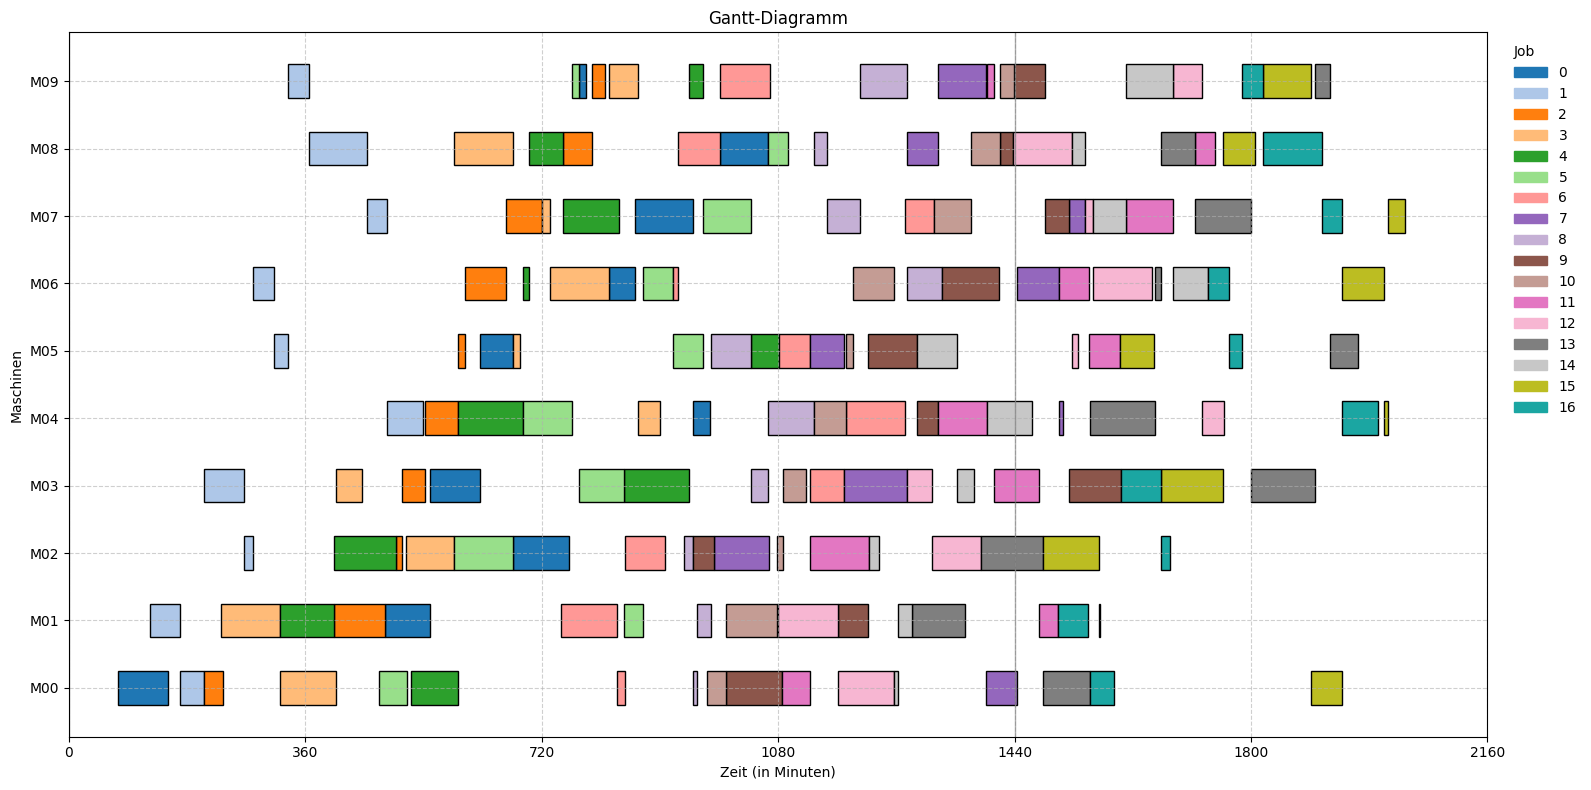

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [6]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## II) Erster Tag (Tag 0)

### a) Simulation

In [7]:
day_length = 1440

In [8]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [9]:
simulation = ProductionSimulation(df_schedule, sigma=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 0 01:15:00] Job 0 started on M00
[Day 0 02:03:00] Job 1 started on M01
[Day 0 02:32:56] Job 1 finished on M01 (after 29 minutes 57 seconds)
[Day 0 03:41:48] Job 0 finished on M00 (after 146 minutes 49 seconds)
[Day 0 03:41:48] Job 1 started on M00
[Day 0 03:51:00] Job 3 started on M01
[Day 0 04:10:32] Job 1 finished on M00 (after 28 minutes 44 seconds)
[Day 0 04:10:32] Job 2 started on M00
[Day 0 04:10:32] Job 1 started on M03
[Day 0 04:31:03] Job 2 finished on M00 (after 20 minutes 31 seconds)
[Day 0 05:15:23] Job 1 finished on M03 (after 64 minutes 51 seconds)
[Day 0 05:15:23] Job 1 started on M02
[Day 0 05:16:21] Job 3 finished on M01 (after 85 minutes 21 seconds)
[Day 0 05:22:00] Job 4 started on M01
[Day 0 05:22:00] Job 3 started on M00
[Day 0 05:25:03] Job 1 finished on M02 (after 09 minutes 40 seconds)
[Day 0 05:25:03] Job 1 started on M06
[Day 0 06:02:58] Job 1 finished on M06 (after 37 minutes 55 seconds)
[Day 0 06:02:58] Job 1 started on M05
[Day 0 06:12:38] Job 3 finish

In [10]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,7,5,877,M09,1324.0,72.0,519.0,1396.0
1,7,6,877,M00,1396.0,47.0,566.0,1443.0
2,7,7,877,M06,1443.0,65.0,631.0,1508.0
3,7,8,877,M04,1508.0,6.0,637.0,1514.0
4,7,9,877,M07,1523.0,25.0,671.0,1548.0
5,9,4,951,M04,1291.0,32.0,372.0,1323.0
6,9,5,951,M06,1329.0,88.0,466.0,1417.0
7,9,6,951,M08,1418.0,19.0,486.0,1437.0
...,...,...,...,...,...,...,...,...
53,16,2,1421,M03,1602.0,61.0,242.0,1663.0


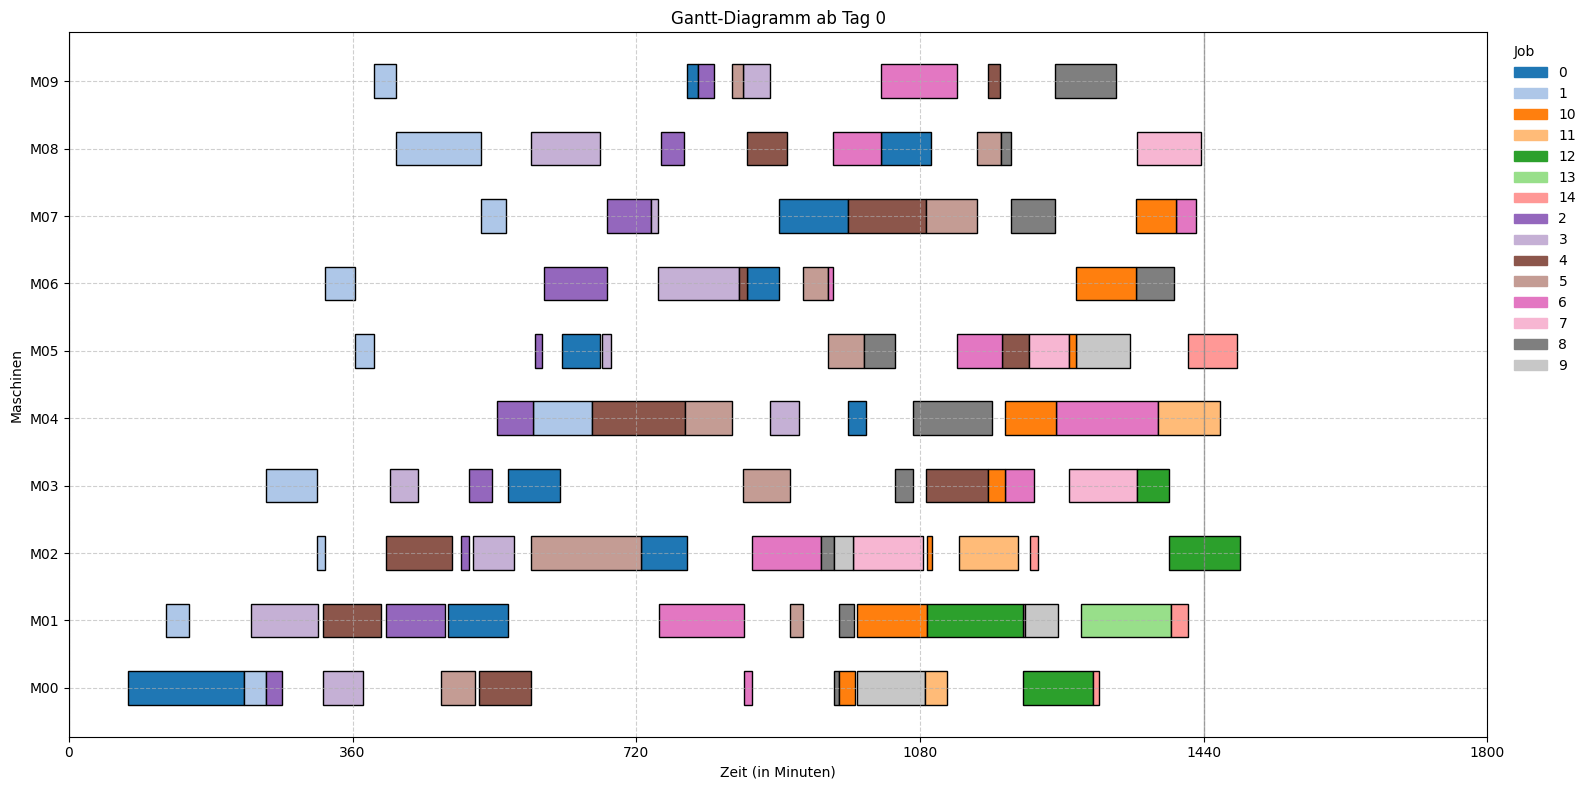

In [11]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [12]:
df_plan_undone 

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,7,5,877,M09,1324.0,72.0,519.0,1396.0
1,7,6,877,M00,1396.0,47.0,566.0,1443.0
2,7,7,877,M06,1443.0,65.0,631.0,1508.0
3,7,8,877,M04,1508.0,6.0,637.0,1514.0
4,7,9,877,M07,1523.0,25.0,671.0,1548.0
5,9,4,951,M04,1291.0,32.0,372.0,1323.0
6,9,5,951,M06,1329.0,88.0,466.0,1417.0
7,9,6,951,M08,1418.0,19.0,486.0,1437.0
...,...,...,...,...,...,...,...,...
53,16,2,1421,M03,1602.0,61.0,242.0,1663.0


In [13]:
df_jobs_times_undone = process_filter.update_times_after_operation_changes(df_jobs_arrivals, df_plan_undone)
df_jobs_times_undone

,Job,Routing_ID,Arrival,Ready Time
0,7,5,877,1440
1,9,7,951,1440
2,10,0,971,1440
3,11,1,976,1440
4,12,2,1045,1440
5,13,3,1129,1440
6,14,4,1158,1440
7,15,5,1361,1440
8,16,6,1421,1440


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [14]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Machine,Arrival,Start,Processing Time,End
99,11,2,M04,976,1382.49,78.81,1461.30
103,12,3,M02,1045,1396.46,89.54,1486.00
108,14,3,M05,1158,1420.23,62.04,1482.27


In [15]:
df_plan_undone

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,7,5,877,M09,1324.0,72.0,519.0,1396.0
1,7,6,877,M00,1396.0,47.0,566.0,1443.0
2,7,7,877,M06,1443.0,65.0,631.0,1508.0
3,7,8,877,M04,1508.0,6.0,637.0,1514.0
4,7,9,877,M07,1523.0,25.0,671.0,1548.0
5,9,4,951,M04,1291.0,32.0,372.0,1323.0
6,9,5,951,M06,1329.0,88.0,466.0,1417.0
7,9,6,951,M08,1418.0,19.0,486.0,1437.0
...,...,...,...,...,...,...,...,...
53,16,2,1421,M03,1602.0,61.0,242.0,1663.0


In [16]:
df_reschedule = lp_ft_reschedule.solve_jssp_with_fixed_ops(df_plan_undone, df_jobs_times_undone, 
                                                           df_execution_important, reschedule_start = 1440,
                                                           solver= "HiGHS", msg=False, 
                                                           timeLimit=max_time, gapRel= 0.10)
df_reschedule

BigM: 4000

Solver-Informationen:
  Summe Flow Times        : 7048.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 263
  Anzahl Constraints      : 456
  Laufzeit                : ~0.36 Sekunden


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,10,8,971,M08,1440.0,44.0,513.0,1484.0
1,10,9,971,M09,1484.0,21.0,534.0,1505.0
2,11,3,976,M09,1473.0,11.0,508.0,1484.0
3,11,4,976,M03,1584.0,69.0,677.0,1653.0
4,11,5,976,M01,1653.0,28.0,705.0,1681.0
5,11,6,976,M06,1694.0,46.0,764.0,1740.0
6,11,7,976,M05,1740.0,46.0,810.0,1786.0
7,11,8,976,M07,1801.0,72.0,897.0,1873.0
...,...,...,...,...,...,...,...,...
53,7,8,877,M04,1694.0,6.0,823.0,1700.0


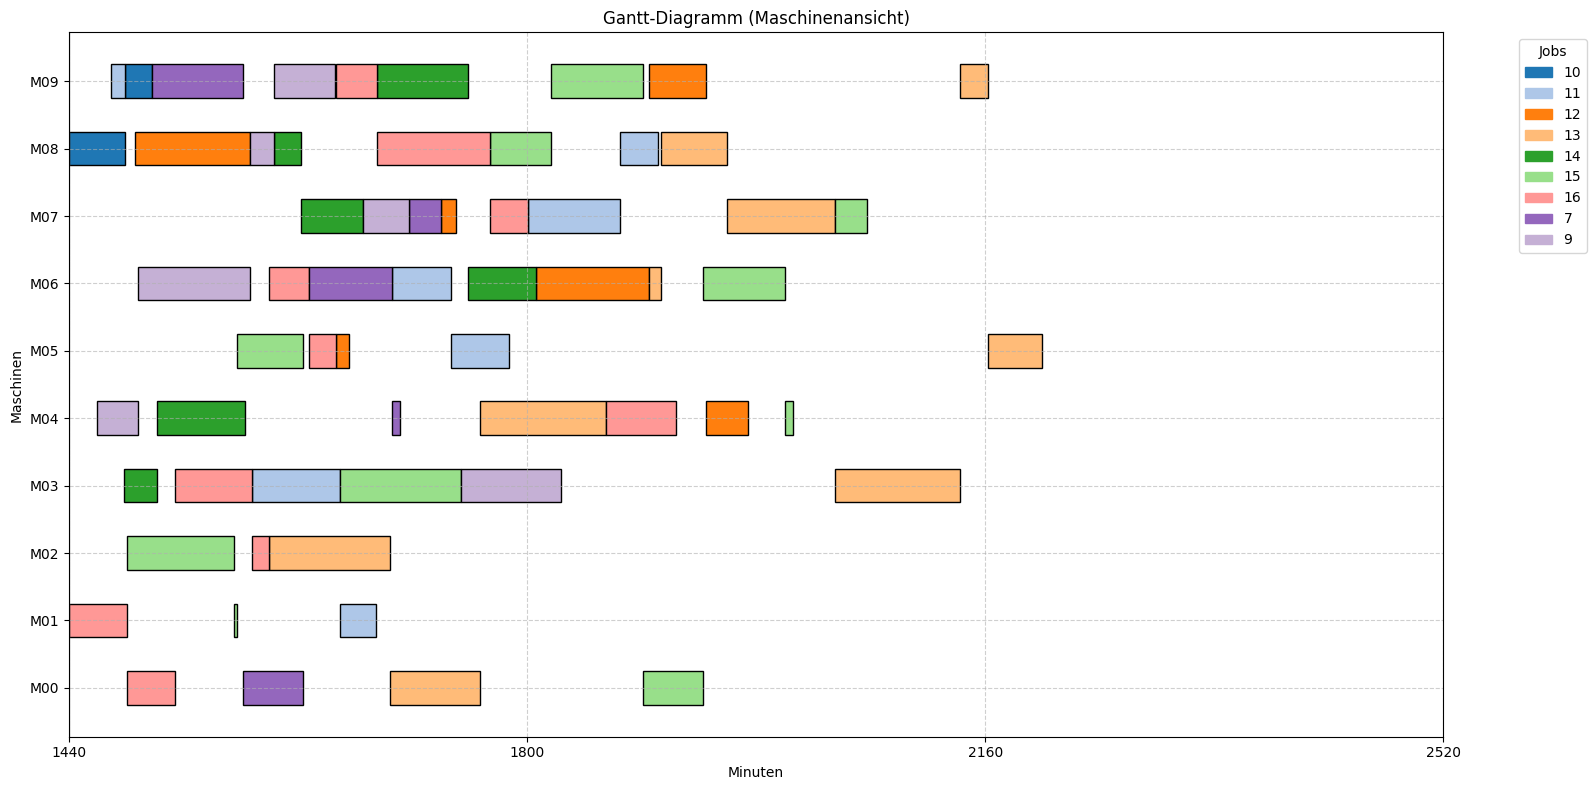

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [17]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

## Simulation + neuer Schedule 

In [18]:
df_combined = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_combined

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Flow time
0,0,0,M00,75,75.00,146.81,221.81,NaN
1,0,1,M01,75,481.00,76.04,557.04,NaN
2,0,2,M03,75,557.04,66.64,623.68,NaN
3,0,3,M05,75,626.00,47.38,673.38,NaN
4,0,4,M02,75,725.92,58.90,784.82,NaN
5,0,5,M09,75,784.82,12.91,797.73,NaN
6,0,6,M06,75,860.44,40.14,900.58,NaN
7,0,7,M07,75,900.58,87.48,988.06,NaN
...,...,...,...,...,...,...,...,...
162,7,8,M04,877,1694.00,6.00,1700.00,823.0


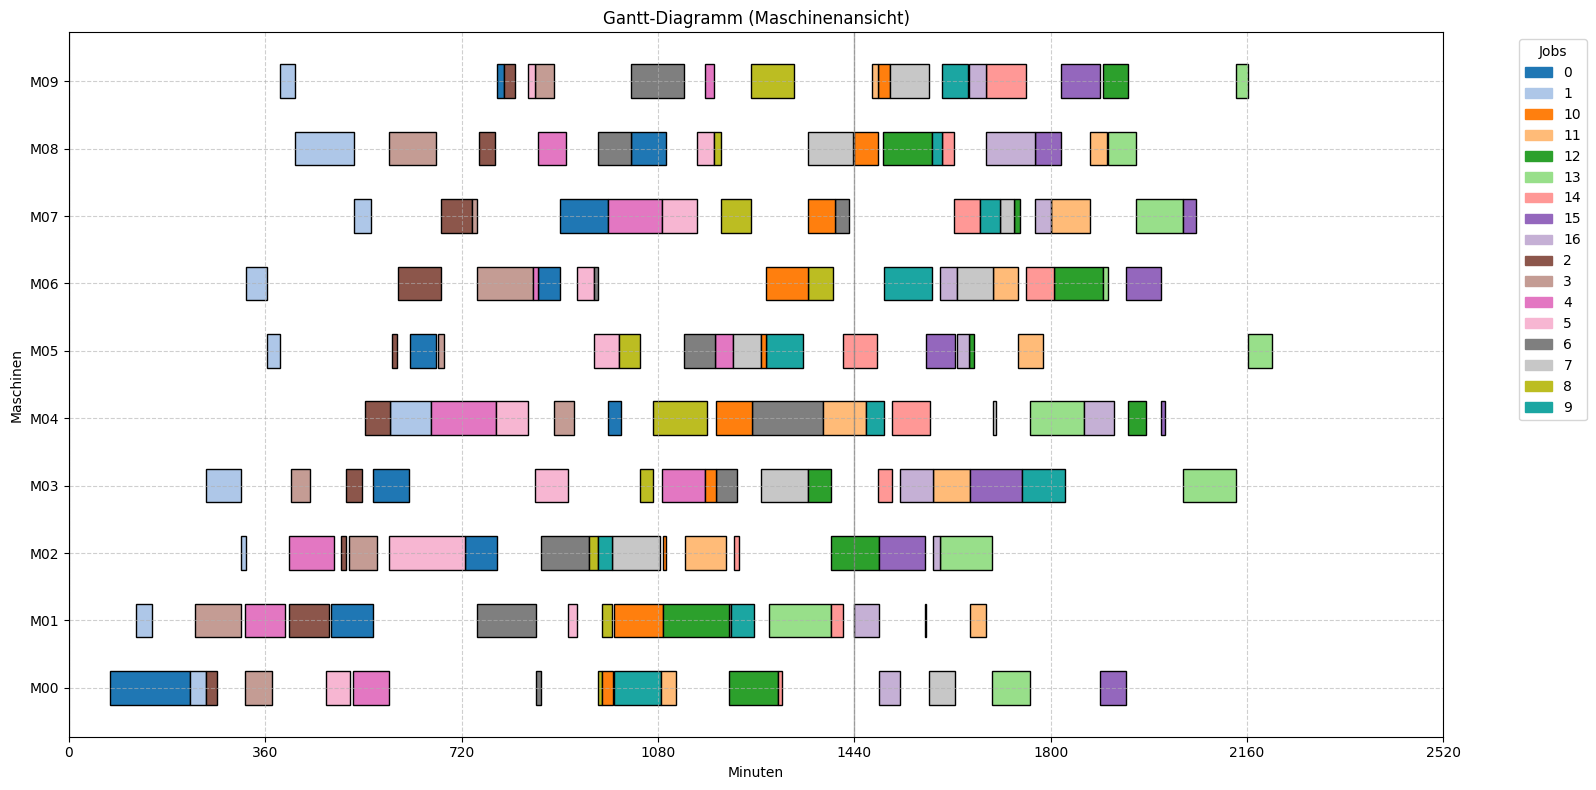

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [19]:
df = df_combined
show.plot_gantt_machines(df)
check.is_machine_conflict_free(df)
check.is_operation_sequence_correct(df)
check.is_job_timing_correct(df)
check.is_start_correct(df)